# ICTP_Mosquito_WingBeat_Sound_Classification_TinyML
- TinyML - Edge Impulse Model Training analysis 
- M.Rovai @30Nov2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display

## Analizyng Audio raw sample

- From Edge Impulse Studio `Data Aquisition - Export Data` Tab, download to your computer a zip file with the .wav raw data captured.
- Upload on /content one (or more) .wav samples

### Aedes Aegypti

In [17]:
# @ Mac
!ls ../data/dataset/aedes_aegypti

16khz_0_10130f.wav                   16khz_1_11-16-2016-111839 10130f.wav
16khz_0_11-16-2016-111457 10130f.wav 16khz_2_10130f.wav
16khz_0_11-16-2016-111839 10130f.wav 16khz_2_11-16-2016-111839 10130f.wav
16khz_1_10130f.wav                   16khz_3_10130f.wav
16khz_1_11-16-2016-111457 10130f.wav 16khz_3_11-16-2016-111839 10130f.wav


In [101]:
file_path = '../data/dataset/aedes_aegypti/'
file = '16khz_1_10130f.wav'

In [102]:
audio, sr = librosa.load(file_path+file, sr=16_000)
sample_rate

16000

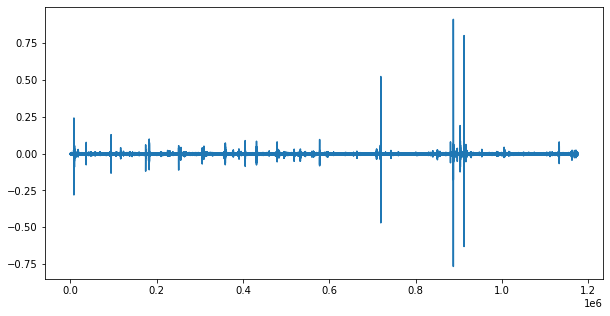

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(audio);

In [67]:
IPython.display.Audio(data=audio, rate=sr)

In [125]:
def fft(file_path, file, title = '', sr=16_000):  
    audio, sr = librosa.load(file_path+file, sr=sr)
    plt.figure(figsize=(10, 5))
    plt.plot(audio);
    plt.xlabel('time')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Time Domain')
    
    plt.figure(figsize=(10, 5))
    for x in range (0, len(audio)-sr, sr//4):
        sample = audio[x:(x+16000)]
        yf = scipy.fftpack.fft(sample)
        plt.plot(2.0/sr * np.abs(yf[1:sr//8]))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    return audio, sr

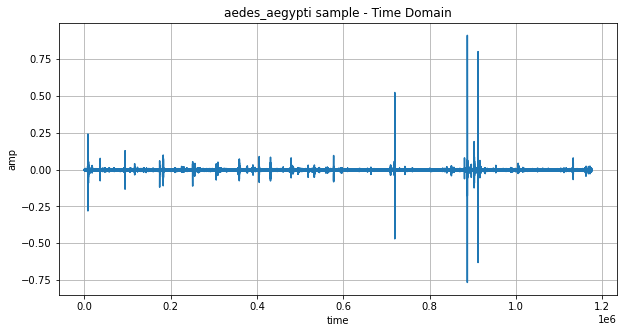

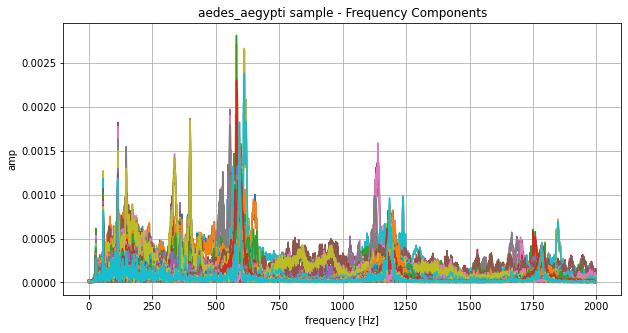

In [126]:
file_path = '../data/dataset/aedes_aegypti/'
file = '16khz_1_10130f.wav'
audio, sr = fft(file_path, file, title = 'aedes_aegypti')

In [127]:
def spectogram(audio, title='', sr=sr):
    X = librosa.stft(audio)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.title(title+' sample - Spectogram')
    plt.colorbar();

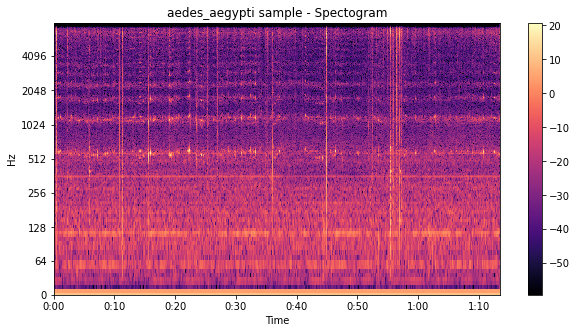

In [128]:
spectogram(audio, title='aedes_aegypti')

### Aedes Albopictus

In [119]:
!ls ../data/dataset/aedes_albopictus

16khz_0_11-16-2016-125240 albopictus f.wav
16khz_0_albof.wav
16khz_1_11-16-2016-125240 albopictus f.wav
16khz_1_albof.wav
16khz_2_11-16-2016-125240 albopictus f.wav
16khz_2_albof.wav
16khz_3_11-16-2016-125240 albopictus f.wav
16khz_3_albof.wav
16khz_4_11-16-2016-125240 albopictus f.wav
16khz_4_albof.wav


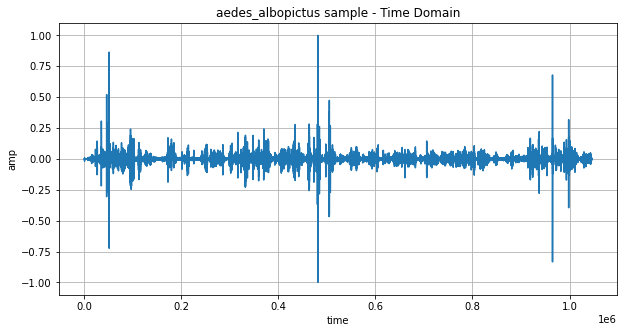

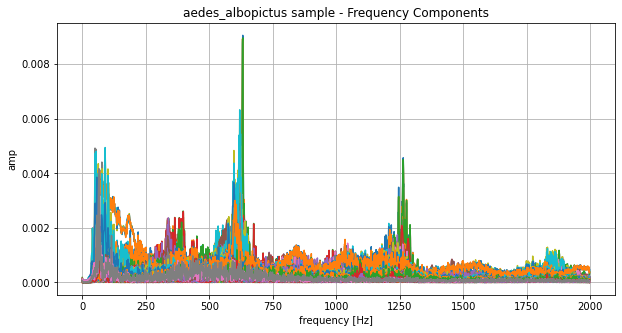

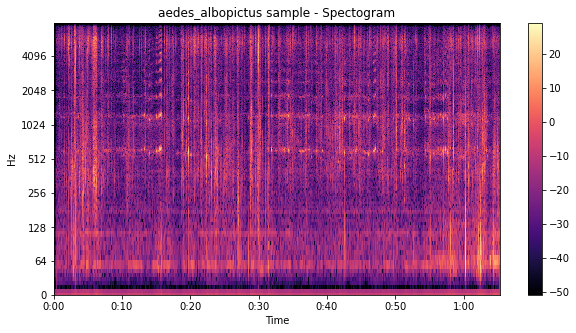

In [129]:
file_path = '../data/dataset/aedes_albopictus/'
file = '16khz_0_11-16-2016-125240 albopictus f.wav'
audio, sr = fft(file_path, file, title = 'aedes_albopictus')
spectogram(audio, title='aedes_albopictus')

## Analysing Edge Impulse Model Training

Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [3]:
import numpy as np
import requests

API_KEY = 'ei_f5a6a812c273d90b3921c6e95313a7e8c1b866acb152078eda3e1ce1a03bfd80'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/65237/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/65237/training/5/y')


Store the data in a temporary file, and load it back through Numpy.

In [ ]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [ ]:
X.shape, Y.shape

In [ ]:
image = X[0]
img_length = image.shape[0]
img_length

In [ ]:
columns = 65
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
image.shape

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(image.T);

Define our labels and split the data up in a test and training set:

In [144]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "aegypti", "albopictus", "noise", "other" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [145]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

In [146]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=5)

callbacks = [early_stop]

Train the model:

In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 65), 65), input_shape=(input_length, )))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax', name='y_pred'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 79, 65)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 79, 32)            6272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 64)            6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [149]:
LR = 0.001
BS = 32
EPOCHS = 100

In [150]:
# this controls the learning rate
opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = BS
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/100
211/211 - 2s - loss: 0.9268 - accuracy: 0.5546 - val_loss: 0.6366 - val_accuracy: 0.7365
Epoch 2/100
211/211 - 1s - loss: 0.5366 - accuracy: 0.7913 - val_loss: 0.4509 - val_accuracy: 0.8287
Epoch 3/100
211/211 - 1s - loss: 0.3958 - accuracy: 0.8570 - val_loss: 0.3766 - val_accuracy: 0.8543
Epoch 4/100
211/211 - 2s - loss: 0.3290 - accuracy: 0.8838 - val_loss: 0.3304 - val_accuracy: 0.8763
Epoch 5/100
211/211 - 1s - loss: 0.2845 - accuracy: 0.8982 - val_loss: 0.3033 - val_accuracy: 0.8882
Epoch 6/100
211/211 - 1s - loss: 0.2563 - accuracy: 0.9070 - val_loss: 0.2915 - val_accuracy: 0.8864
Epoch 7/100
211/211 - 1s - loss: 0.2312 - accuracy: 0.9159 - val_loss: 0.2666 - val_accuracy: 0.8965
Epoch 8/100
211/211 - 1s - loss: 0.2117 - accuracy: 0.9241 - val_loss: 0.2510 - val_accuracy: 0.9096
Epoch 9/100
211/211 - 1s - loss: 0.1934 - accuracy: 0.9320 - val_loss: 0.2694 - val_accuracy: 0.9007
Epoch 10/100
211/211 - 1s - loss: 0.1806 - accuracy: 0.9339 - val_loss: 0.2397 - val_accura

Epoch 82/100
211/211 - 1s - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.1074 - val_accuracy: 0.9703
Epoch 83/100
211/211 - 1s - loss: 0.0208 - accuracy: 0.9926 - val_loss: 0.1343 - val_accuracy: 0.9601
Epoch 84/100
211/211 - 1s - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.1243 - val_accuracy: 0.9631
Epoch 85/100
211/211 - 1s - loss: 0.0272 - accuracy: 0.9929 - val_loss: 0.1132 - val_accuracy: 0.9631
Epoch 86/100
211/211 - 1s - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.1209 - val_accuracy: 0.9655
Epoch 87/100
211/211 - 1s - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.0908 - val_accuracy: 0.9792
Epoch 88/100
211/211 - 1s - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.0761 - val_accuracy: 0.9822
Epoch 89/100
211/211 - 1s - loss: 0.0327 - accuracy: 0.9921 - val_loss: 0.0785 - val_accuracy: 0.9798
Epoch 90/100
211/211 - 2s - loss: 0.0152 - accuracy: 0.9951 - val_loss: 0.0994 - val_accuracy: 0.9738
Epoch 91/100
211/211 - 1s - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.0737 - v

In [151]:
import matplotlib.pyplot as plt
def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', res], loc='lower right')
    plt.show()

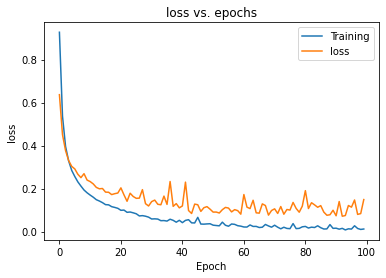

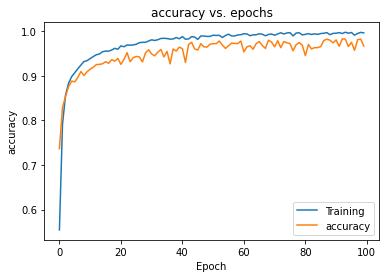

In [152]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')

In [5]:
# Save the model to disk
# model.save('saved_model')